(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import Antibiotic

# Load CairoMakie for plotting
using CairoMakie
import PairPlots
import ColorSchemes

# Import basic math libraries
import StatsBase
import LinearAlgebra
import Random
import Distributions

# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.theme_makie!()

# Evolutionary dynamics on a fitness and mutational landscape

In this notebook we will explore a simple model of evolution on a fitness
landscape with an explicit mutational landscape.

The setting is the following:

Let $\underline{x}(t) = (x_1(t), x_2(t), \cdots, x_N(t))$ be an $N$ dimensional
vector of phenotypes at time $t$. The fitness for a given environment $E$ is
a scalar function $F_E(\underline{x})$ such that
$$
F_E: \mathbb{R}^N \to \mathbb{R},
\tag{1}
$$
i.e, the coordinates in phenotype space map to a fitness value. As a particular
fitness function we will consider a series of Gaussian fitness peaks, i.e.,
$$
F_E(\underline{x}) = 
\sum_{p=1}^P A_p 
\exp\left(
    -\frac{1}{2}
    (\underline{x} - \underline{\hat{x}}^{(p)})^T 
    \Sigma_p^{-1} 
    (\underline{x} - \underline{\hat{x}}^{(p)})
\right),
\tag{2}
$$
where $P$ is the number of peaks, $A_p$ is the amplitude of the $p$-th peak,
$\underline{\hat{x}}^{(p)}$ is the $N$-dimensional vector of optimal phenotypes
for the $p$-th peak, and $\Sigma_p$ is the $N \times N$ covariance matrix for
the $p$-th peak. This formulation allows for multiple peaks in the fitness
landscape, each potentially having different heights, widths, and covariance
structures between dimensions. The covariance matrix $\Sigma_p$ captures
potential interactions between different phenotypic dimensions, allowing for
more complex and realistic fitness landscapes.

In the same vein, we define a mutational landscape $M(\underline{x})$ as a scalar
function that maps a phenotype to a mutational effect, i.e.,
$$
M: \mathbb{R}^N \to \mathbb{R},
\tag{3}
$$
where $M(\underline{x})$ is related to the probability of a genotype mapping to
a phenotype $\underline{x}$. As a particular mutational landscape we will
consider a set of negative Gaussian peaks that will serve as "mutational
barriers" that limit the range of phenotypes that can be reached. The deeper the
peak, the more difficult it is to reach the phenotype associated with that peak.
This idea is captured by the following mutational landscape:
$$
M(\underline{x}) = \sum_{p=1}^P -B_p \exp\left(-\frac{1}{2}(\underline{x} - \underline{\hat{x}}^{(p)})^T \Sigma_p^{-1} (\underline{x} - \underline{\hat{x}}^{(p)})\right),
\tag{4}
$$
where $B_p$ is the depth of the $p$-th peak, and $\underline{\hat{x}}^{(p)}$ is the $N$-dimensional vector of optimal phenotypes for the $p$-th peak.

Both, the fitness landscape and the mutational landscape are built on Gaussian
functions. Let's therefore define a `struct` to hold the parameters of a single
peak.

In [2]:
@doc raw"""
    GaussianPeak

A struct to hold the parameters of a single Gaussian peak.

# Fields
- `amplitude::AbstractFloat`: The amplitude of the peak.
- `mean::AbstractVector`: The mean of the peak.
- `covariance::AbstractMatrix`: The covariance matrix of the peak.
"""
struct GaussianPeak
    amplitude::AbstractFloat
    mean::AbstractVector
    covariance::AbstractMatrix
end

GaussianPeak

Next, let's define a function to evaluate the fitness landscape at a given
phenotype.

In [45]:
@doc raw"""
    fitness(peak::GaussianPeak, x::AbstractVecOrMat; min_value::AbstractFloat=0.0)
    fitness(peaks::Vector{GaussianPeak}, x::AbstractVecOrMat; min_value::AbstractFloat=0.0)

Calculate the fitness value for a given phenotype `x` based on Gaussian peak(s).

# Arguments
- `peak::GaussianPeak`: A single Gaussian peak.
- `peaks::Vector{GaussianPeak}`: A vector of Gaussian peaks.
- `x::AbstractVecOrMat`: The phenotype(s) for which to calculate the fitness.
  Can be a vector for a single phenotype or a matrix for multiple phenotypes,
  where each column corresponds to a phenotype.
- `min_value::AbstractFloat=1.0`: The minimum fitness value to be added to the
  Gaussian contribution.

# Returns
The calculated fitness value(s).

# Description
The first method computes the fitness for a single Gaussian peak, while the
second method computes the sum of fitness values for multiple Gaussian peaks. In
both cases, the `min_value` is added to the Gaussian contribution to ensure a
minimum fitness level.
"""
function fitness(
    peak::GaussianPeak, x::AbstractVecOrMat; min_value::AbstractFloat=1.0
)
    # Calculate the Gaussian peak
    gaussian = peak.amplitude * exp(
        -0.5 *
        (x - peak.mean)' *
        LinearAlgebra.inv(peak.covariance) *
        (x - peak.mean)
    )
    # Return the fitness by shifting the Gaussian peak by the minimum value
    return gaussian + min_value
end

function fitness(
    peaks::Vector{GaussianPeak},
    x::AbstractVecOrMat;
    min_value::AbstractFloat=1.0
)
    # Sum the Gaussian contributions from all peaks
    total_gaussian = sum(
        peak.amplitude *
        exp(
            -0.5 *
            (x - peak.mean)' *
            LinearAlgebra.inv(peak.covariance) *
            (x - peak.mean)
        )
        for peak in peaks
    )
    # Return the fitness by shifting the Gaussian peak by the minimum value
    return total_gaussian + min_value
end

fitness (generic function with 2 methods)

Let's test the fitness function with a single Gaussian peak.

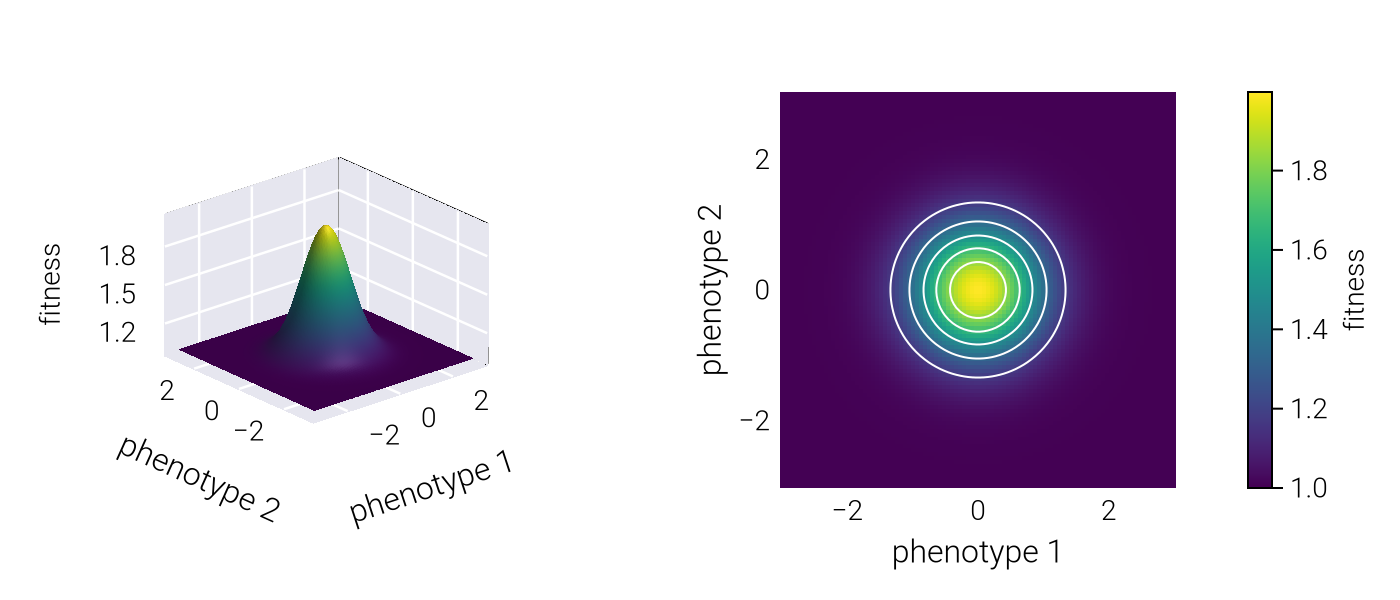

In [46]:
# Define peak parameters
amplitude = 1.0
mean = [0.0, 0.0]
covariance = [0.5 0.0; 0.0 0.5]

# Create peak
fit_peak = GaussianPeak(amplitude, mean, covariance)

# Define range of phenotypes to evaluate
x = range(-3, 3, length=100)
y = range(-3, 3, length=100)

# Create meshgrid
F = fitness.(Ref(fit_peak), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(700, 300))

# Add axis for 3D plot
ax3 = Axis3(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    zlabel="fitness",
)

# Add axis for contour plot
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
)

# Plot fitness landscape
surface!(ax3, x, y, F, color=F, colormap=:viridis)

# Plot a heatmap of the fitness landscape
hm = heatmap!(ax2, x, y, F)

# Add a colorbar
Colorbar(fig[1, 3], hm, label="fitness")

# Plot contour plot
contour!(ax2, x, y, F, color=:white)

fig

Next, let's define a function to evaluate the mutational landscape at a given
phenotype.

In [39]:
@doc raw"""
    mutational_landscape(
        peak::Union{GaussianPeak, Vector{GaussianPeak}}, 
        x::AbstractVecOrMat;
        max_value::Float64 = 1.0
    )

Calculate the mutational landscape value for a given phenotype `x` based on
Gaussian peak(s).

# Arguments
- `peak::Union{GaussianPeak, Vector{GaussianPeak}}`: A single Gaussian peak or a
  vector of Gaussian peaks.
- `x::AbstractVecOrMat`: The phenotype(s) for which to calculate the mutational
  landscape. Can be a vector for a single phenotype or a matrix for multiple
  phenotypes, where each column corresponds to a phenotype.
- `max_value::Float64`: Optional. The maximum value of the landscape. Default is
  1.0.

# Returns
The calculated mutational landscape value(s).
"""
function mutational_landscape(
    peak::GaussianPeak, x::AbstractVecOrMat; max_value::AbstractFloat=1.0
)
    # Calculate the Gaussian peak
    gaussian = peak.amplitude * exp(
        -0.5 *
        (x - peak.mean)' *
        LinearAlgebra.inv(peak.covariance) *
        (x - peak.mean)
    )
    # Return the mutational landscape by inverting the Gaussian peak shifted by
    # the maximum value
    return -(gaussian - max_value)
end

function mutational_landscape(
    peaks::Vector{GaussianPeak},
    x::AbstractVecOrMat;
    max_value::AbstractFloat=1.0
)
    # Sum the Gaussian contributions from all peaks
    total_gaussian = sum(
        peak.amplitude *
        exp(
            -0.5 *
            (x - peak.mean)' *
            LinearAlgebra.inv(peak.covariance) *
            (x - peak.mean)
        )
        for peak in peaks
    )
    # Return the mutational landscape by inverting the Gaussian peak shifted by
    # the maximum value
    return -(total_gaussian - max_value)
end

mutational_landscape (generic function with 2 methods)

Let's test the mutational landscape function with four Gaussian peaks in the 
corners of a square in phenotype space.

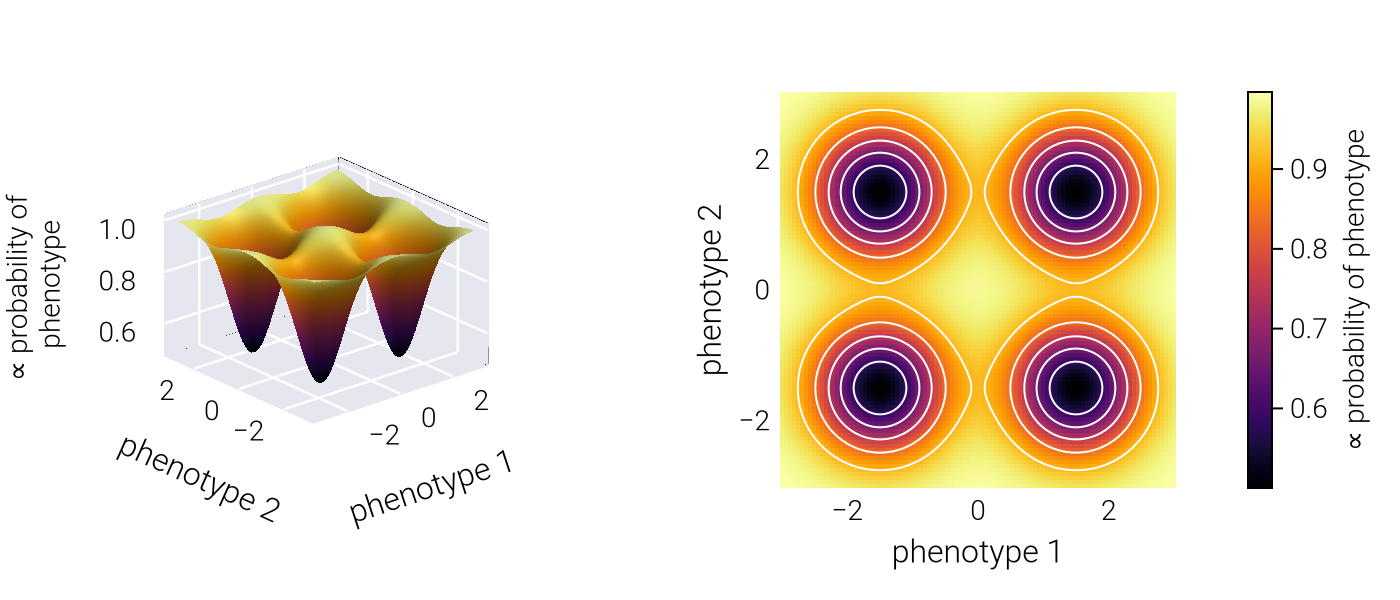

In [79]:
# Define peak parameters
amplitude = 0.5
means = [
    [-1.5, -1.5],
    [1.5, -1.5],
    [1.5, 1.5],
    [-1.5, 1.5],
]
covariance = [0.45 0.0; 0.0 0.45]

# Create peak
mut_peaks = GaussianPeak.(Ref(amplitude), means, Ref(covariance))

# Define range of phenotypes to evaluate
x = range(-3, 3, length=100)
y = range(-3, 3, length=100)

# Create meshgrid
M = mutational_landscape.(Ref(mut_peaks), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(700, 300))

# Add axis for 3D plot
ax3 = Axis3(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    zlabel="∝ probability of \nphenotype",
)

# Add axis for contour plot
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
)

# Plot mutational landscape
surface!(ax3, x, y, M, color=M, colormap=:inferno)

# Plot a heatmap of the mutational landscape
hm = heatmap!(ax2, x, y, M, colormap=:inferno)

# Add a colorbar
Colorbar(fig[1, 3], hm, label="∝ probability of phenotype")

# Plot contour plot
contour!(ax2, x, y, M, color=:white)

fig

## Evolutionary dynamics

### Metropolis-Hastings Algorithm in Evolutionary Dynamics


The Metropolis-Hastings algorithm is a Markov Chain Monte Carlo (MCMC) method
used to sample from a target probability distribution $\pi(\underline{x})$. In
our evolutionary context, $\pi(\underline{x})$ can be thought of as the
steady-state distribution of phenotypes under the combined influence of
selection and mutation. We can define this distribution as:
$$
\pi(\underline{x}) \propto \exp\left(
    -\beta U(\underline{x})
\right),
\tag{6}
$$
here, $\beta$ is an inverse temperature parameter (from statistical mechanics)
that controls the level of stochasticity in the system. A higher $\beta$ means
the system is more likely to move towards higher fitness and mutational
accessibility.

### Proposal Distribution

At each step, we propose a new phenotype $\underline{x}{\prime}$ from a proposal
distribution $q(\underline{x}{\prime} | \underline{x})$. For simplicity, we can
use a symmetric proposal distribution, such as a Gaussian centered at the
current phenotype. Furthere, we constrain the proposal distribution to be
symmetric, i.e.,
$$
q(x | x') = q(x' | x).
\tag{7}
$$
This symmetry simplifies the acceptance probability later on.

### Acceptance Probability

The acceptance probability  $P_{\text{accept}}$  for moving from
$\underline{x}$  to  $\underline{x}{\prime}$  is given by:
$$
P_{\text{accept}} = 
\min\left(1, 
    \frac{\pi(\underline{x}{\prime}) q(\underline{x} | \underline{x}{\prime})}
    {\pi(\underline{x}) q(\underline{x}{\prime} | \underline{x})}
\right).
\tag{8}
$$

Given the symmetry of the proposal distribution,  $q(\underline{x}{\prime} |
\underline{x}) = q(\underline{x} | \underline{x}{\prime})$ , so the acceptance
probability simplifies to:
$$
P_{\text{accept}} = \min\left(
    1, 
    \frac{\pi(\underline{x}{\prime})}{\pi(\underline{x})}
    \right) = \min\left(
    1, 
    e^{\beta [\ln F_E(\underline{x}{\prime}) + \ln M(\underline{x}{\prime})] - 
    \beta [\ln F_E(\underline{x}) + \ln M(\underline{x})]}
    \right).
\tag{9}
$$
This can be rewritten as
$$
P_{\text{accept}} = \min\left(
    1,
    \frac{F_E(\underline{x}{\prime})^β M(\underline{x}{\prime})^β}
    {F_E(\underline{x})^β M(\underline{x})^β}
\right),
\tag{10}
$$
This expression shows that the acceptance probability depends on the difference
in fitness and mutational accessibility between the current and proposed
phenotypes.

Let's now implement the Metropolis-Hastings algorithm in code.

In [7]:
@doc raw"""
    evo_metropolis_hastings(x0, fitness_peaks, mut_peaks, β, µ, n_steps)

Perform evolutionary Metropolis-Hastings algorithm to simulate phenotypic
evolution.

# Arguments
- `x0::AbstractVecOrMat`: Initial phenotype vector or matrix.
- `fitness_peaks::Union{GaussianPeak, Vector{GaussianPeak}}`: Fitness landscape
  defined by one or more Gaussian peaks.
- `mut_peaks::Union{GaussianPeak, Vector{GaussianPeak}}`: Mutational landscape
  defined by one or more Gaussian peaks.
- `β::AbstractFloat`: Inverse temperature parameter controlling selection
  strength.
- `µ::AbstractFloat`: Mutation step size standard deviation.
- `n_steps::Int`: Number of steps to simulate.

# Returns
- `Matrix{Float64}`: Matrix of phenotypes, where each column represents a step
  in the simulation.

# Description
This function implements the Metropolis-Hastings algorithm to simulate
phenotypic evolution in a landscape defined by fitness and mutational
accessibility. It uses the following steps:

1. Initialize the phenotype trajectory with the given starting point.
2. For each step: 
   a. Propose a new phenotype by adding Gaussian noise. 
   b. Calculate the fitness and mutational landscape values for the new 
      phenotype.
   c. Compute the acceptance probability based on the ratio of new and current 
      values. 
   d. Accept or reject the proposed phenotype based on the acceptance 
      probability.
3. Return the complete phenotype trajectory.

The acceptance probability is calculated using the simplified form: 
P_accept = min(1, (F_E(x_new) * M(x_new)) / (F_E(x) * M(x)))

where F_E is the fitness function and M is the mutational landscape function.
"""
function evo_metropolis_hastings(
    x0::AbstractVector,
    fitness_peaks::Union{GaussianPeak,Vector{GaussianPeak}},
    mut_peaks::Union{GaussianPeak,Vector{GaussianPeak}},
    β::Real,
    µ::Real,
    n_steps::Int,
)
    # Initialize array to hold phenotypes
    x = Matrix{Float64}(undef, length(x0), n_steps + 1)
    # Set initial phenotype
    x[:, 1] = x0

    # Compute fitness and mutational landscape at initial phenotype
    fitness_val = fitness(fitness_peaks, x0)
    mut_val = mutational_landscape(mut_peaks, x0)

    # Loop over steps
    for t in 1:n_steps
        # Propose new phenotype
        x_new = x[:, t] + µ * randn(length(x0))

        # Calculate fitness and mutational landscape
        fitness_val_new = fitness(fitness_peaks, x_new)
        mut_val_new = mutational_landscape(mut_peaks, x_new)

        # Compute acceptance probability
        P_accept = min(
            1, (fitness_val_new * mut_val_new / (fitness_val * mut_val))^β
        )

        # Accept or reject proposal
        if rand() < P_accept
            # Accept proposal
            x[:, t+1] = x_new
            # Update fitness and mutational landscape
            fitness_val = fitness_val_new
            mut_val = mut_val_new
        else
            # Reject proposal
            x[:, t+1] = x[:, t]
        end
    end # for
    return x
end # function



evo_metropolis_hastings

Let's test this function with the previously defined fitness and mutational
landscapes.

In [107]:
Random.seed!(42)

# Define peak parameters
amplitude = 5.0
mean = [0.0, 0.0]
covariance = [3.0 0.0; 0.0 3.0]
# Create peak
fit_peak = GaussianPeak(amplitude, mean, covariance)
# Define peak parameters
amplitude = 1.0
means = [
    [-1.5, -1.5],
    [1.5, -1.5],
    [1.5, 1.5],
    [-1.5, 1.5],
]
covariance = [0.45 0.0; 0.0 0.45]

# Create peak
mut_peaks = GaussianPeak.(Ref(amplitude), means, Ref(covariance))

# Set initial phenotype
x0 = [-2.5, -2.5]

# Set parameters
β = 10.0
µ = 0.1
n_steps = 300

# Run Metropolis-Hastings algorithm
x_traj = evo_metropolis_hastings(x0, fit_peak, mut_peaks, β, µ, n_steps)

2×301 Matrix{Float64}:
 -2.5  -2.42116  -2.49449  -2.58578  …  0.235899  0.154246  0.154246
 -2.5  -2.58799  -2.65821  -2.59504     0.460891  0.433683  0.433683

Let's plot the trajectory of the phenotypes in phenotype space.

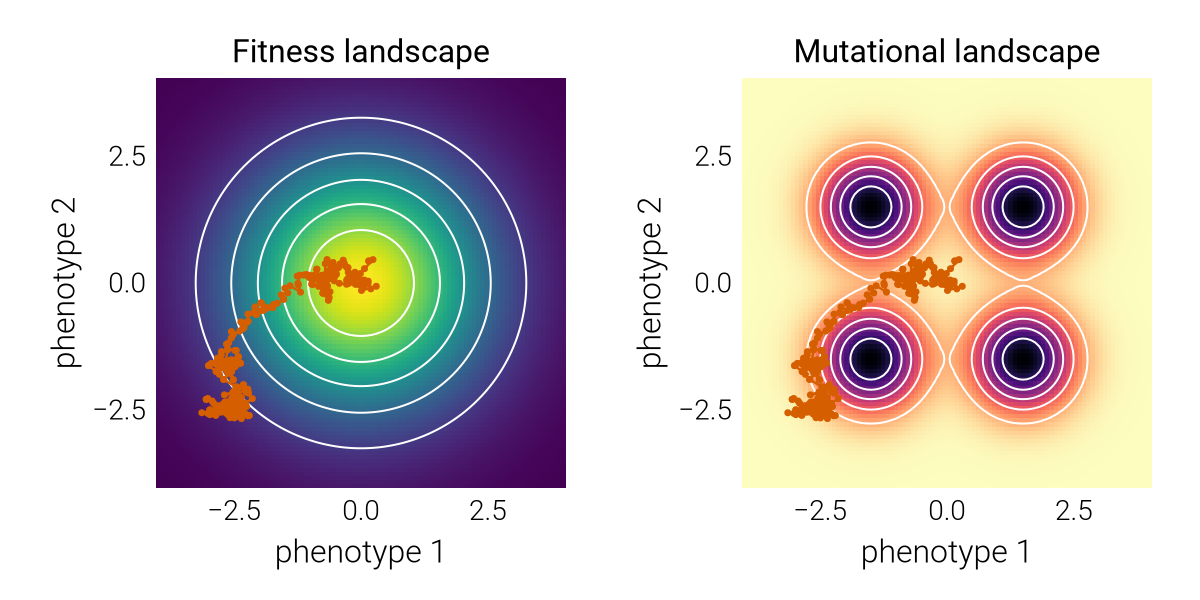

In [111]:
# Define range of phenotypes to evaluate
x = range(-4, 4, length=100)
y = range(-4, 4, length=100)

# Create meshgrid
F = fitness.(Ref(fit_peak), [[x, y] for x in x, y in y])
M = mutational_landscape.(Ref(mut_peaks), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for trajectory in fitness landscape
ax1 = Axis(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Fitness landscape",
)
# Add axis for trajectory in mutational landscape
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Mutational landscape",
)

# Plot a heatmap of the fitness landscape
heatmap!(ax1, x, y, F, colormap=:viridis)
# Plot heatmap of mutational landscape
heatmap!(ax2, x, y, M, colormap=:magma)

# Plot contour plot
contour!(ax1, x, y, F, color=:white)
contour!(ax2, x, y, M, color=:white)

# Plot trajectory
scatterlines!.(
    [ax1, ax2],
    Ref(x_traj[1, :]),
    Ref(x_traj[2, :]),
    color=ColorSchemes.seaborn_colorblind[4],
    markersize=5
)

fig

Let's coarse-grain the trajectory by averaging over blocks of 10 steps.

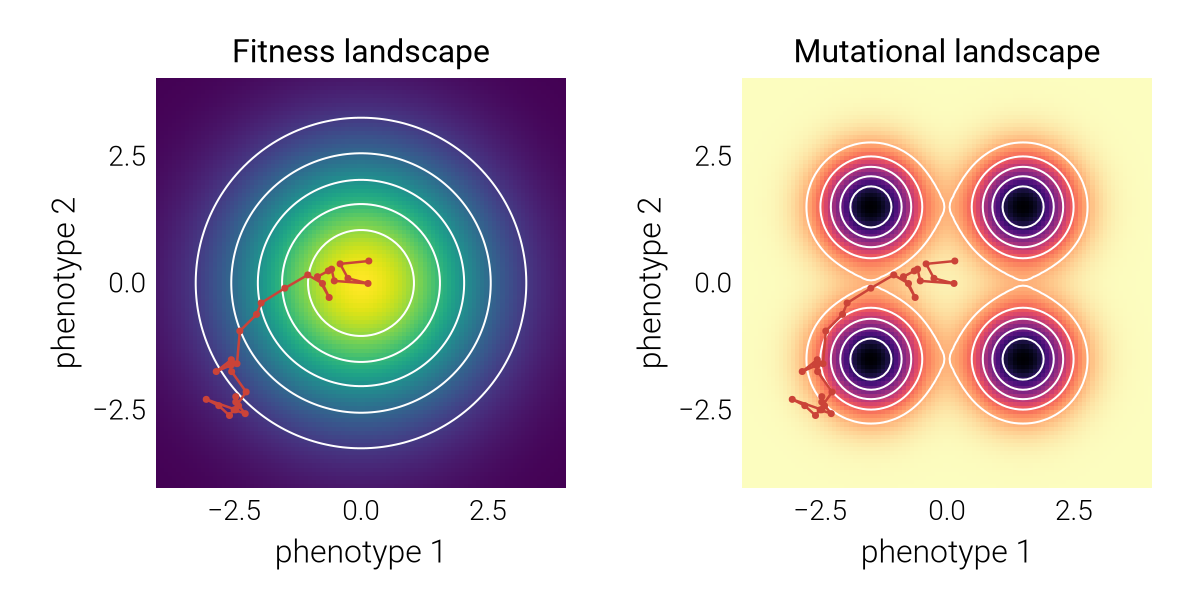

In [118]:
# Define range of phenotypes to evaluate
x = range(-4, 4, length=100)
y = range(-4, 4, length=100)

# Create meshgrid
F = fitness.(Ref(fit_peak), [[x, y] for x in x, y in y])
M = mutational_landscape.(Ref(mut_peaks), [[x, y] for x in x, y in y])

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for trajectory in fitness landscape
ax1 = Axis(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Fitness landscape",
)
# Add axis for trajectory in mutational landscape
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Mutational landscape",
)

# Plot a heatmap of the fitness landscape
heatmap!(ax1, x, y, F)
# Plot heatmap of mutational landscape
heatmap!(ax2, x, y, M, colormap=:magma)

# Plot contour plot
contour!(ax1, x, y, F, color=:white)
contour!(ax2, x, y, M, color=:white)

# Plot trajectory
scatterlines!.(
    [ax1, ax2],
    Ref(x_traj[1, 1:10:end]),
    Ref(x_traj[2, 1:10:end]),
    # color=ColorSchemes.seaborn_colorblind[4],
    color=Antibiotic.viz.colors()[:red],
    markersize=5
)

fig

Let's plot the energy for the phenotypes in the trajectory.

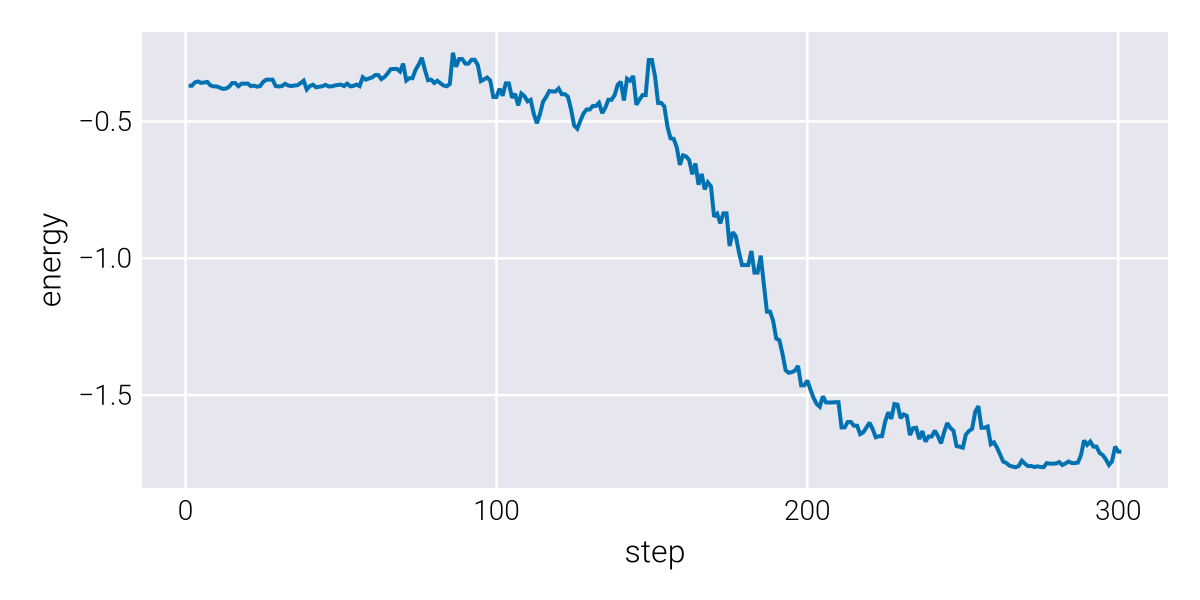

In [119]:
# Initialize array to hold energy
U = Vector{Float64}(undef, n_steps + 1)

# Loop over steps
for (i, x) in enumerate(eachcol(x_traj))
    U[i] = -log(fitness(fit_peak, x)) - log(mutational_landscape(mut_peaks, x))
end

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for energy
ax = Axis(
    fig[1, 1],
    xlabel="step",
    ylabel="energy",
)

# Plot energy
lines!(ax, U)

fig


Let's now repeat the simulation multiple times and plot all different 
trajectories.

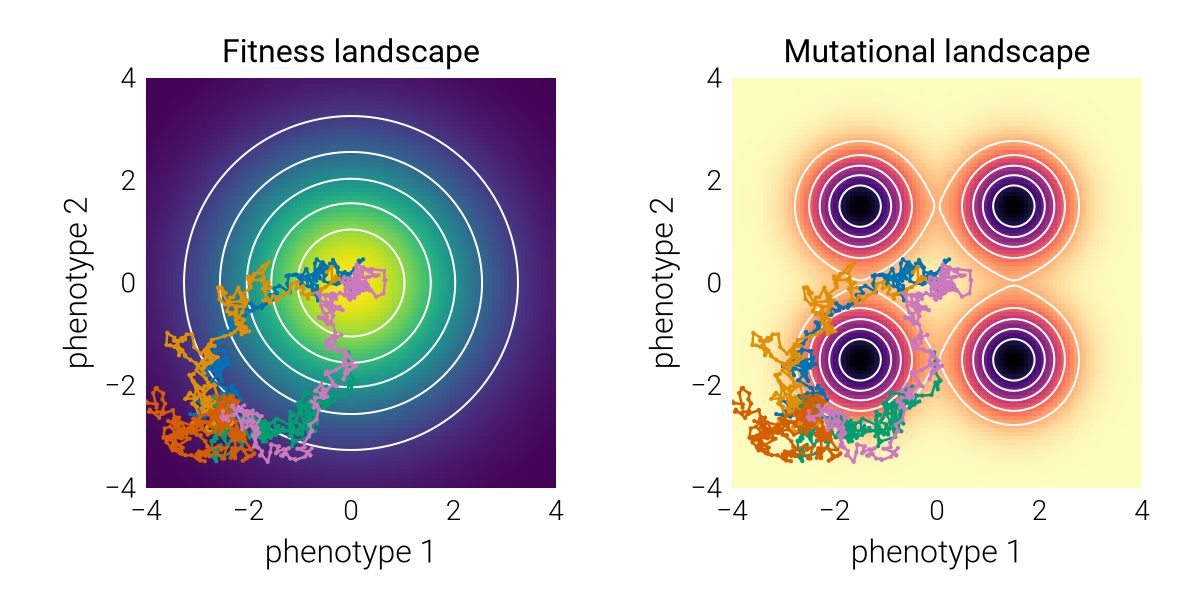

In [122]:
Random.seed!(42)

# Define number of simulations
n_sim = 5

# Run simulations
x_traj_list = [
    evo_metropolis_hastings(x0, fit_peak, mut_peaks, β, µ, n_steps)
    for _ in 1:n_sim
]

# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for fitness landscape
ax1 = Axis(
    fig[1, 1],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Fitness landscape",
)
# Add axis for mutational landscape
ax2 = Axis(
    fig[1, 2],
    xlabel="phenotype 1",
    ylabel="phenotype 2",
    aspect=AxisAspect(1),
    title="Mutational landscape",
)

# Plot fitness landscape
heatmap!(ax1, x, y, F)
# Plot heatmap of mutational landscape
heatmap!(ax2, x, y, M, colormap=:magma)

# Plot contour plot
contour!(ax1, x, y, F, color=:white)
contour!(ax2, x, y, M, color=:white)

# Loop over simulations
for (i, x_traj) in enumerate(x_traj_list)
    # Plot trajectory
    scatterlines!.(
        [ax1, ax2],
        Ref(x_traj[1, :]),
        Ref(x_traj[2, :]),
        color=ColorSchemes.seaborn_colorblind[i],
        markersize=3
    )
end

# Set limits
xlims!(ax1, -4, 4)
ylims!(ax1, -4, 4)
xlims!(ax2, -4, 4)
ylims!(ax2, -4, 4)

fig